In [1]:
import math
import pandas as pd
import datetime, os
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

import threading

from scipy.stats import norm
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special 

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import chaospy

In [2]:
#Fix the seed value for reproducibility and fix the number of digits for printouts
npr.seed(42)
np.set_printoptions(precision=10, suppress=True)

#sample size
sample_size = 1000

#Time to maturity from 0.11 year to 1.1 years 
tau = chaospy.J(chaospy.Uniform(0.1, 1.1)).sample(sample_size, rule="sobol")
#Risk free rate from almost 0 to 10%
r = chaospy.J(chaospy.Uniform(0.0001, 0.1)).sample(sample_size, rule="sobol")
#volatility of the variance (5% to 50%)
sigma = chaospy.J(chaospy.Uniform(0.05, 0.5)).sample(sample_size, rule="sobol")
#Correlation (-90% to +0%)
rho = chaospy.J(chaospy.Uniform(-0.9, 0.)).sample(sample_size, rule="sobol")
#initial variance (5% to 50%)
nu = chaospy.J(chaospy.Uniform(0.05, 0.5)).sample(sample_size, rule="sobol")
#Long term mean (5% to 50%)
theta = chaospy.J(chaospy.Uniform(0.05, 0.5)).sample(sample_size, rule="sobol")
#Mean reversion speed 
kappa = chaospy.J(chaospy.Uniform(0.1, 1.9)).sample(sample_size, rule="sobol")
#Spot price 
S = np.full(shape=sample_size,fill_value=1, dtype=np.int)
#Strikes 
K = np.arange(0.8, 1.3, 0.05)

#integrate from -400 to 400 for ease of computation
#(note that for lim=-200,200 the greeks tails were not pretty)
limit = 400

According to Antoine [Modern Computational Finance: AAD and Parallel Simulations] it is considered best practice in finance to apply quasi-random numbers generated by Sobol’s algorithm in instead of (pseudo-)random numbers. The benefit of using sobol numbers is the lower discrepancy (they fill the space of possibilities more evenly). The lower discrepancy helps with faster convergance and more stable estimates of financial product values and risk sensitivities. Yet, pseudo-random numbers build the basis for most simulation efforts and is according to Hilpish [Python for finance] still the benchmark.

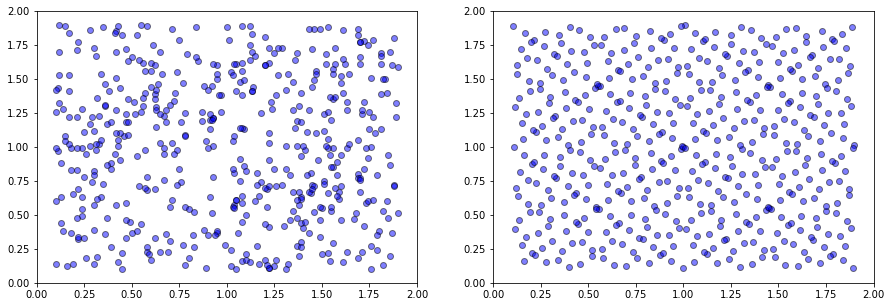

In [3]:
'''
left: normal random datapoints for kappa
right: sobol datapoints for kappa
'''
kappaaa = npr.randint(10, 190+1, size = (sample_size,2)) / 100
kappaa = chaospy.J(chaospy.Uniform(0.1, 1.9), chaospy.Uniform(0.1, 1.9)).sample(sample_size, rule="sobol")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].scatter(kappaaa[:500,0],kappaaa[:500,1], color = 'blue', edgecolor = 'black',  alpha=0.5)
axes[0].set_xlim([0., 2])
axes[0].set_ylim([0., 2])
axes[1].scatter(kappaa[0,:500],kappaa[1,:500], color = 'blue', edgecolor = 'black',  alpha=0.5)
axes[1].set_xlim([0., 2])
axes[1].set_ylim([0., 2]);

fig.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Other/sobol.png',
            bbox_inches='tight');

LINKS:
- https://medium.com/@antoine_savine/sobol-sequence-explained-188f422b246b

- https://betatim.github.io/posts/quasi-random-numbers/

- https://en.wikipedia.org/wiki/Sobol_sequence